In [ ]:
#| default_exp models.tsmixer

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

# TSMixer

Time-Series Mixer (`TSMixer`), a novel architecture designed by stacking multi-layer perceptrons (`MLPs`) that focuses on mixing time and feature dimensions to make better predictions.It is designed for time series forecasting, specifically in scenarios where the data is multivariate and exhibits complex dynamics. 

(`TSMixer`) presents a promising approach to time series forecasting by effectively leveraging both temporal and cross-variate information through a simple yet powerful architecture.

(`TSMixer`) demonstrates superior performance compared to the state-of-the-art alternatives on the challenging and large scale M5 benchmark

**References**<br>
-[Si-An Chen, Chun-Liang Li, Nathanael C. Yoder, Sercan Ö. Arık,Tomas Pfister. "TSMixer: An All-MLP Architecture for Time Series Forecasting".](https://arxiv.org/pdf/2303.06053.pdf)

![Figure 1. TSMixer Model Architecture.](imgs_models/tsmixer.png) 

In [ ]:
#| hide
from fastcore.test import test_eq
from nbdev.showdoc import show_doc
import matplotlib.pyplot as plt

In [ ]:
#| export
import neuralforecast
from typing import Optional

import torch
import torch.nn as nn
import neuralforecast

from neuralforecast.losses.pytorch import MAE
from neuralforecast.common._base_multivariate import BaseMultivariate

C:\Sapna\Nixtla_Project\neuralforecast\neuralforecast\utils.py:281: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  AirPassengersPanel["y_[lag12]"].fillna(AirPassengersPanel["y"], inplace=True)


In [ ]:
#| export

class TransposeLayer(nn.Module):
    def __init__(self, dim0, dim1):
        super(TransposeLayer, self).__init__()
        self.dim0 = dim0
        self.dim1 = dim1

    def forward(self, x):
        return torch.transpose(x, self.dim0, self.dim1)

class ResBlock(nn.Module):
    def __init__(self, inputs, activation=nn.ReLU, dropout=0., ff_dim=None):
        super(ResBlock, self).__init__()

        self.norm = nn.LayerNorm
        
        # Temporal Linear
        self.temporal_linear = nn.Sequential(
            self.norm(inputs, eps=1e-5),  
            TransposeLayer(1,2), # [Batch, Channel, Input Length]                                               
            nn.Linear(inputs[-1],inputs[-1], bias=False),
            activation(), 
            TransposeLayer(1, 2),
            nn.Dropout(dropout)
            
        )

        # Feature Linear
        self.feature_linear = nn.Sequential(
            self.norm(inputs[1:], eps=1e-5),
            nn.Linear(inputs[-1],ff_dim, bias=False),  # [Batch, Input Length, FF_Dim]
            activation(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, inputs[-1], bias=False),  # [Batch, Input Length, Channel]
            activation(),
            nn.Dropout(dropout)
        )
        
    def forward(self, inputs):
        # Temporal Linear
        # print("Input shape before temporal_linear:", inputs.shape)
        x = self.temporal_linear(inputs)
        # print("Output shape after temporal_linear:", x.shape)
        res = x + inputs

        # Feature Linear
        # print("Input shape before feature_linear:", res.shape)
        x = self.feature_linear(res)
        # print("Output shape after feature_linear:", x.shape)
        return x + res

In [ ]:
#| export
class TSMixer(BaseMultivariate):
    """ TSMixer
    
    Basic TSMixer Model architecture.    
    This deep neural network model builds upon the idea that linear models are effective for capturing time dependencies. 
    The TSMixer architecture combines linear models with non-linearities, stacking them in alternating layers for time and feature domains. 
    This approach leverages both temporal patterns and covariate information. 
    The model includes time-mixing and feature-mixing MLPs, temporal projection, residual connections, and 2D normalization.
    It is trained using ADAM stochastic gradient descent.
    The network accepts static, historic and future exogenous data, flattens the inputs and learns fully connected relationships against the target variable.
    
    **Parameters:**<br> 
    `h`: int, forecast horizon.<br>
    `input_size`: int, considered autorregresive inputs (lags), y=[1,2,3,4] input_size=2 -> lags=[1,2].<br> 
    `n_series`: int, number of time-series.<br>
    `loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
    `max_steps`: int=1000, maximum number of training steps.<br>
    `val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
    `n_series`:int, the number of time series in the multivariate time series data. <br>
    `batch_size`: int=32, number of different series in each batch.<br>
    `step_size`: int=1, step size between each window of temporal data.<br>
    `num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
    `early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
    `hidden_size`: int, number of units for each layer of the MLP.<br>
    `n_layers`: int, number of layers for the MLP.<br>
    `scaler_type`: str='identity', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
    `futr_exog_list`: str list, future exogenous columns.<br>
    `hist_exog_list`: str list, historic exogenous columns.<br>
    `stat_exog_list`: str list, static exogenous columns.<br>
    `scaler_type`: str='identity', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
    `num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
    `drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
    `random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
    `alias`: str, optional, Custom name of the model.<br>    
    `**trainer_kwargs`: int, keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>    
    
    `Additional parameters for TSMixer model:-  
    `activation`: str, activation from ['ReLU', 'Softplus', 'Tanh', 'SELU', 'LeakyReLU', 'PReLU', 'Sigmoid'].<br> 
    `n_block`: int , number of mixer layers/residual blocks.<br>
    `dropout`: float=0., dropout regularization.<br>
    `ff_dim`:int, number of features or characteristics the model should consider when processing information about the data. <br>    
    `target_slice`: list[start,end] the target_slice parameter is used to customize the predicted sequence the model should focus on. When target_slice=None - In this case, the model predicts the entire sequence.<br>   
    """
    
    # Class attributes
    SAMPLING_TYPE = 'windows'
    
    def __init__(self,
                 h,                          # prediction length                 
                 input_size,                 # Autoregressive terms
                 loss=MAE(),
                 valid_loss=None,
                 learning_rate: float = 1e-3,
                 max_steps: int = 1000,
                 val_check_steps: int = 100,
                 step_size: int = 1,
                 num_lr_decays: int = 0,
                 early_stop_patience_steps: int =-1,
                 scaler_type: str = 'robust',
                 futr_exog_list=None,
                 hist_exog_list=None,
                 stat_exog_list=None,
                 num_workers_loader: int = 0,
                 drop_last_loader: bool = False,
                 random_seed: int =1, 
                 alias=None,
                 
                 ###### Specific to TSMixer                 
                 n_series:int =None,        # Number of input channels
                 batch_size: int = 32,      # The input batch size
                 n_block: int =None,        # Number of residual blocks
                 dropout:float =.01,        # Droput for MLP layers
                 ff_dim:int = None,         # Feature dimensions for each layers
                 target_slice:list =None,   # Prediction window user wnats to analyze. target_slice would be from 0 to n_series - 1.
                 ######
                 **trainer_kwargs
                ):
        
  
        super(TSMixer, self).__init__(
                                      h=h,
                                      input_size=input_size,
                                      loss=loss,
                                      valid_loss=valid_loss,
                                      learning_rate=learning_rate,
                                      max_steps=max_steps,
                                      val_check_steps=val_check_steps,                                      
                                      step_size=step_size,
                                      num_lr_decays=num_lr_decays,
                                      early_stop_patience_steps=early_stop_patience_steps,
                                      scaler_type=scaler_type,
                                      futr_exog_list=futr_exog_list,
                                      hist_exog_list=hist_exog_list,
                                      stat_exog_list=stat_exog_list,
                                      num_workers_loader=num_workers_loader,
                                      drop_last_loader=drop_last_loader,
                                      random_seed=random_seed, 
                                      alias=alias,
                                      n_series=n_series,
                                      batch_size=batch_size,
                                      #####
                                      **trainer_kwargs
                                     )

        #Parameters specific to TSMixer.
        self.batch_size = batch_size
        self.n_block = n_block
        self.dropout = dropout
        self.ff_dim = ff_dim
        self.target_slice = target_slice  
        self.n_series = n_series
        
        # Create TSMixer-specific modules with learnable parameters        
        input_shape = (input_size, n_series)  # Assuming batch_size, input_size, and n_series are user inputs
        
        self.res_blocks = nn.ModuleList([ResBlock(inputs = input_shape, dropout=dropout, ff_dim=ff_dim) for _ in range(self.n_block)])

        # Output shape after feature_linear: torch.Size([1, 1, 12, 2])
        # Size after applying output layer: torch.Size([1, 1, 12, 2])
        
        self.output_layer = nn.Sequential(
            TransposeLayer(1,2),
            # nn.Linear(input_shape[-1], self.h * self.n_series),  # Adjust the output size
            nn.Linear(input_shape[-1],input_shape[-1]),            
            TransposeLayer(1,2),
        )
        
    def forward(self, windows_batch):

        insample_y = windows_batch['insample_y']
        x = insample_y
        
        X = x.unsqueeze(1).permute(0,1,2,3).contiguous()
        
        for res_block in self.res_blocks:            
            x = res_block(X)

        if self.target_slice is not None:
            x = x[:, :, :, self.target_slice]
            
        # print("x after slicing:",x.size())
    
        x = self.output_layer(x)
        
        # print("Size after applying output layer:", x.size()) 
        
        x = x.view(x.size(0), self.n_series,-1,self.h).contiguous()  # Reshape to match the sliced input
        
        # print("Size after reshaping:", x.size())  
        
        x = TransposeLayer(1, 2)(x)
          
        y_pred = x.reshape(x.size(0), self.h,self.n_series)
        
        y_pred = self.loss.domain_map(y_pred)

        # print("Forecast values:",y_pred)
        # print("Size of y_pred:", y_pred.size())
        
        return y_pred

## Usage Examples

In [ ]:
#| eval: false
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from torchsummary import summary

from neuralforecast import NeuralForecast
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic
from neuralforecast.losses.pytorch import MAE
from neuralforecast.core import NeuralForecast
from neuralforecast.models import Informer, Autoformer, FEDformer, PatchTST, TSMixer

Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

Y_train_df.head()

,unique_id,ds,y,trend,y_[lag12]
0,Airline1,1949-01-31,112.0,0,112.0
1,Airline1,1949-02-28,118.0,1,118.0
2,Airline1,1949-03-31,132.0,2,132.0
3,Airline1,1949-04-30,129.0,3,129.0
4,Airline1,1949-05-31,121.0,4,121.0


In [ ]:
#| eval: false

model = TSMixer(h=12,
                input_size=12,
                n_series=2,
                # stat_exog_list=['airline1'],
                # futr_exog_list=['trend'],
                scaler_type='robust',
                max_steps=100,
                early_stop_patience_steps=-1,
                val_check_steps=10,
                learning_rate=1e-3,
                loss=MAE(),
                # valid_loss=None,
                batch_size=32,
                n_block=1,
                ff_dim=32,
                target_slice=slice(0,2)
                )

fcst = NeuralForecast(models=[model], freq='ME')
fcst.fit(df=Y_train_df, val_size=12)

forecasts = fcst.predict(futr_df=Y_test_df)

Seed set to 1


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Predicting: |                                                                                                 …

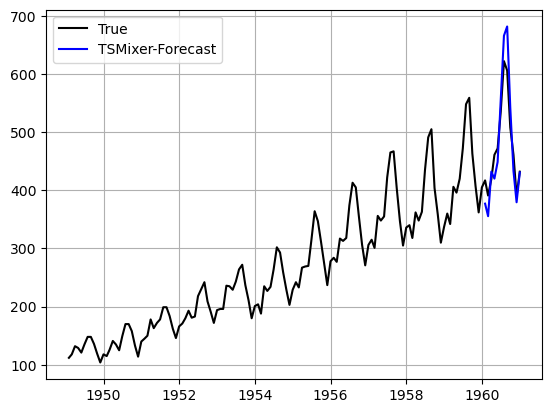

In [ ]:
#| eval: false
# Plot quantile predictions
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['TSMixer'], c='blue', label='TSMixer-Forecast')
plt.legend()
plt.grid()

Using `cross_validation` to forecast multiple historic values.

In [ ]:
n_time = len(AirPassengersPanel.ds.unique())
val_size = int(.2 * n_time)
test_size = int(.2 * n_time)
val_size=val_size
test_size=test_size
print(val_size,test_size)
print(len(AirPassengersPanel))

28 28
288


In [ ]:
#| eval: false
fcst = NeuralForecast(models=[model], freq='ME')
forecasts = fcst.cross_validation(df=AirPassengersPanel, static_df=AirPassengersStatic, n_windows=2, step_size=12)

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Predicting: |                                                                                                 …

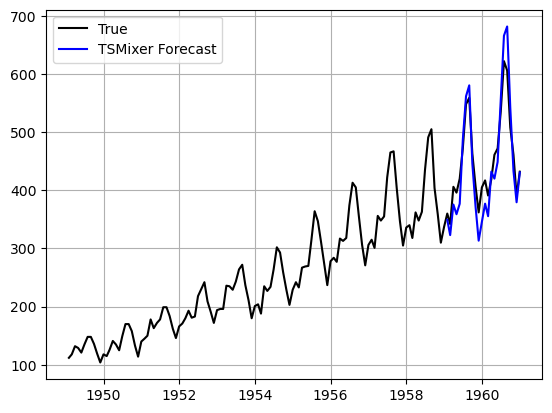

In [ ]:
#| eval: false
# Plot quantile predictions
forecasts = pd.DataFrame(forecasts)
forecasts.index

Y_hat_df = forecasts[forecasts.index=='Airline1']
Y_df = AirPassengersPanel[AirPassengersPanel['unique_id']=='Airline1']

plt.plot(Y_df['ds'], Y_df['y'], c='black', label='True')
plt.plot(Y_hat_df['ds'], Y_hat_df['TSMixer'], c='blue', label='TSMixer Forecast')
plt.legend()
plt.grid()